# Identification des facteurs de risque avec NLP

In [2]:
!pip3 install yellowbrick
!pip3 install wordcloud

You should consider upgrading via the '/home/adam/anaconda3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 364 kB 4.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/adam/anaconda3/bin/python -m pip install --upgrade pip' command.


In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import pprint
import nltk
import json
import os
import re 

from pos_viz   import PosTagVisualizer
from wordcloud import WordCloud, STOPWORDS

nltk.download("averaged_perceptron_tagger")
nltk.download("tagsets")

random.seed(52)

%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /home/adam/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


# Chargement du fichier metadata 


In [2]:
metadata = pd.read_csv("./metadata/metadata.csv")
metadata.head()

/home/adam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cord_uid                                       sha source_x  \
0  zjufx4fo  b2897e1277f56641193a6db73825f707eed3e4c9      PMC   
1  ymceytj3  e3d0d482ebd9a8ba81c254cc433f314142e72174      PMC   
2  wzj2glte  00b1d99e70f779eb4ede50059db469c65e8c1469      PMC   
3  2sfqsfm1  cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0      PMC   
4  i0zym7iq  dde02f11923815e6a16a31dd6298c46b109c5dfa      PMC   

                                               title  \
0  Sequence requirements for RNA strand transfer ...   
1  Crystal structure of murine sCEACAM1a[1,4]: a ...   
2  Synthesis of a novel hepatitis C virus protein...   
3  Structure of coronavirus main proteinase revea...   
4  Discontinuous and non-discontinuous subgenomic...   

                        doi      pmcid   pubmed_id license  \
0  10.1093/emboj/20.24.7220  PMC125340  11742998.0     unk   
1   10.1093/emboj/21.9.2076  PMC125375  11980704.0     unk   
2  10.1093/emboj/20.14.3840  PMC125543  11447125.0   no-cc   
3      10.1093/emboj/cdf327  PMC126080  12093723.0     unk   
4      10.1093/emboj/cdf635  PMC136939  12456663.0     unk   

                                            abstract publish_time  \
0  Nidovirus subgenomic mRNAs contain a leader se...   2001-12-17   
1  CEACAM1 is a member of the carcinoembryonic an...   2002-05-01   
2  Hepatitis C virus (HCV) is an important human ...   2001-07-16   
3  The key enzyme in coronavirus polyprotein proc...   2002-07-01   
4  Arteri-, corona-, toro- and roniviruses are ev...   2002-12-01   

                                             authors           journal  \
0  Pasternak, Alexander O.; van den Born, Erwin; ...  The EMBO Journal   
1  Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...  The EMBO Journal   
2  Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...            EMBO J   
3  Anand, Kanchan; Palm, Gottfried J.; Mesters, J...  The EMBO Journal   
4  van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...  The EMBO Journal   

   Microsoft Academic Paper ID WHO #Covidence arxiv_id  has_pdf_parse  \
0                          NaN            NaN      NaN           True   
1                          NaN            NaN      NaN           True   
2                          NaN            NaN      NaN           True   
3                          NaN            NaN      NaN           True   
4                          NaN            NaN      NaN           True   

   has_pmc_xml_parse  full_text_file  \
0               True  custom_license   
1               True  custom_license   
2               True  custom_license   
3               True  custom_license   
4               True  custom_license   

                                                 url  
0  http://europepmc.org/articles/pmc125340?pdf=re...  
1  http://europepmc.org/articles/pmc125375?pdf=re...  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...  
3  http://europepmc.org/articles/pmc126080?pdf=re...  
4  http://europepmc.org/articles/pmc136939?pdf=re...

In [3]:
abstracted         = metadata[["cord_uid","sha", "abstract"]] 
NUMBER_OF_ARTICLES = abstracted.shape[0]

## Affichage d'un wordcloud 

Nous définissions d'abord la fonction qui permet d'afficher le wordcloud

In [4]:
def afficherWordCloud(text):
    wordcloud = WordCloud(background_color='white',
        stopwords=set(STOPWORDS),
        max_words=150,
        max_font_size=42, 
        scale=5).generate(text)
    plt.imshow(wordcloud)
    plt.imsave("word_cloud.png", wordcloud)
    plt.axis("off")
    plt.show()
    

Ainsi nous l'appliquerons dans un premier temps que sur les abstract des articles


In [5]:
new_abstracted = abstracted[abstracted["abstract"].apply(lambda x: isinstance(x, str))]
len(new_abstracted)

#concat_abstract = " ".join(abstracted['abstract'].values)

48757

In [6]:
new_abstracted = new_abstracted[new_abstracted["abstract"].str.contains('coronavirus|covid-19|2019-ncov|sars-cov-2',flags=re.IGNORECASE, regex=True)]
len(new_abstracted)

12945

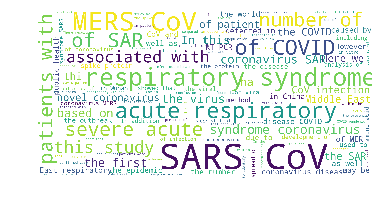

In [7]:
all_abstracts = " ".join(new_abstracted["abstract"].values)
afficherWordCloud(all_abstracts)

## 1 ère Approche : Recherche grammaticale, avec les méthodes nltk

In [8]:
nltk.help.upenn_tagset()


$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [9]:
# Fonction pour faire du preprocessing d'un text
def preprocessText(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    return tagged


def renderTaggedAbstract(uid, tag_list):
        print("Titre               : {}".format(metadata[metadata["cord_uid"] == uid]["title"].values[0]))
        print("Journal             : {}".format(metadata[metadata["cord_uid"] == uid]["journal"].values[0]))
        print("Date de publication : {} \n".format(metadata[metadata["cord_uid"] == uid]["publish_time"].values[0]))
        Visualizer = PosTagVisualizer()
        Visualizer.transform(tag_list)
        
# Tester les 2 fonctions sur les abstracts de 3 articles choisis aléatoirement

for i in range(3):
    index      = random.randint(0,NUMBER_OF_ARTICLES - 1)
    tagged     = preprocessText(abstracted.iloc[index]["abstract"])
    renderTaggedAbstract(abstracted.iloc[index]["cord_uid"], tagged)
    

Titre               : Medical retrieval and needs of infants with bronchiolitis: An analysis by gestational age
Journal             : J Paediatr Child Health
Date de publication : 2012-12-11 

AIM : Viral bronchiolitis is the most common lower respiratory tract infection in children less than 12 months of age . Prematurity is an independent risk factor for disease severity . Many infected infants require hospitalisation and those living in regional centres frequently require transfer to metropolitan hospitals capable of providing assisted ventilation . METHOD : We reviewed infants with bronchiolitis transported by the Victorian Newborn Emergency Transport Service between January 2003 and June 2007 . We compared the clinical presentation and treatment required by infants born preterm with those of their term counterparts . RESULTS : Of the 192 infants transported , 92 were born preterm . Preterm infants were younger at time of transport ( mean post‐menstrual age 41 weeks vs. 45 weeks ) 

## Keyword search dans les articles 

In [29]:
from nltk import bigrams
N_articles     = 1000

sampled        = new_abstracted.sample(N_articles)
search_dict    = {}

In [30]:
for key in sampled['cord_uid']:
    
    search_dict[key]   = {}
    sentences          = nltk.sent_tokenize(sampled[sampled['cord_uid'] == key]["abstract"].values[0])  
    w_sentences        = list(map( lambda x : nltk.RegexpTokenizer(r"\w+").tokenize(x.lower()), sentences))
    search_dict[key]   = {i : w_sentences[i] for i in range(len(sentences))}
        
#pprint.pprint(search_dict['9a1fckvh'][0])

In [ ]:
#S = nltk.sent_tokenize(sampled.iloc[0]["abstract"])
#sentence  = S[0].lower()
#tokenizer = nltk.RegexpTokenizer(r"\w+")
#sentence  = tokenizer.tokenize(sentence)
#print(sentence)
#T =  nltk.Text(nltk.word_tokenize(S[0]))
#print(T[:])
#list(bigrams(T[0:10]))

In [120]:
clean_sentences = []

Query  = [('patients', 'with'), ('associated', 'with'), ('risk', 'of'), ('we','found'), ('covid','patient'), ('were', 'detected')]
Query2 = [('found', 'we')] 

Query3 = [{
    'name': 'smoking',
    'pattern': 'smoki|smoker|cigar|nicotine|cannabis|marijuana'
}, {
    'name': 'diabetes',
    'pattern': 'diabet|insulin|blood sugar|blood glucose|ketoacidosis|hyperglycemi'
}, {
    'name': 'pregnancy',
    'pattern': 'pregnan'
}, {
    'name': 'tuberculosis',
    'pattern': 'tubercul|mtb|\btb[A-Za-z0-9]\b'
}, {
    'name': 'hypertension',
    'pattern': 'hypertension|blood pressure|hbp'
}, {
    'name': 'cancer',
    'pattern': 'cancer'
}, {
    'name': 'neonates',
    'pattern': 'baby|neonate|enfant'
},
    {
    'name': 'liver disease',
    'pattern': 'liver disease'
},{
    'name': 'COPD',
    'pattern': 'COPD'
},{
    'name': 'pulmonary disease',
    'pattern': 'pulm'
},{
    'name': 'race/ethnicity',
    'pattern': 'ethn'
}]
# Inclure l'essai avec lemmatization et sans lemmatization
# Inclure les facteurs de risques
# Inclure des bigrammes avec windows 
def searchFactorsByQuery(query, search_type = 'bigram', big_dist=3, lemmatize = False):
    
    for key in search_dict.keys():

        for index in search_dict[key].keys():
            
            if search_type   == 'bigram':
                
                for bi_gr in query:
                    L_bigrams = bigrams(search_dict[key][index])
                    if bi_gr in L_bigrams:
                        #print('Found match : article {}, sentence {}, on keyword : {}\n'.format(key, index + 1, " ".join(bi_gr)))
                        # Include bold on words taht were found
                        #print(" ".join(search_dict[key][index]))
                        clean_sentences.append(search_dict[key][index])
                        
            elif search_type == 'factor':
                
                for factor in query:
                    sentence = " ".join(search_dict[key][index])
                    result   = re.search(factor['pattern'], sentence)
                    if bool(result) == True:
                        #print('Found match : article {}, sentence {}, on factor : {}\n'.format(key, index + 1, factor['name']))
                        #print(" ".join(search_dict[key][index]))
                        clean_sentences.append(search_dict[key][index])
                        
            elif search_type == 'cust_bigram':
                
                for bi_gr in query: 
                    L_words = search_dict[key][index]
                    if bi_gr[0] in L_words and bi_gr[1] in L_words:
                        if abs(L_words.index(bi_gr[0]) - L_words.index(bi_gr[1])) <= big_dist:
                            #print('Found match : article {}, sentence {}, on keyword : {}\n'.format(key, index + 1, " ".join(bi_gr)))
                            
                            #print(" ".join(search_dict[key][index]))
                            clean_sentences.append(search_dict[key][index])
                
        
searchFactorsByQuery(Query3, search_type = 'factor', big_dist=3, lemmatize = False)

    

In [129]:
print(clean_sentences[:10])

[['in', 'order', 'to', 'achieve', 'the', 'overall', 'victory', 'of', 'the', '2019', 'novel', 'coronavirus', 'disease', 'epidemic', 'in', 'this', 'war', 'rsquo', 'especially', 'to', 'prevent', 'the', 'disease', 'recurrence', 'from', 'rebounding', 'during', 'the', 'resumption', 'of', 'labor', 'the', 'government', 'has', 'not', 'loosened', 'any', 'control', 'of', 'personnel', 'mobility', 'which', 'has', 'obviously', 'affected', 'the', 'normal', 'examination', 'and', 'treatment', 'of', 'lung', 'cancer', 'patients', 'under', 'the', 'influence', 'of', 'this', 'epidemic'], ['during', 'the', 'epidemic', 'period', 'cancer', 'patients', 'with', 'low', 'immunity', 'levels', 'face', 'the', 'double', 'ordeals', 'of', 'disease', 'and', 'epidemic', 'situation'], ['among', 'the', 'infected', 'cancer', 'patients', 'lung', 'cancer', 'is', 'the', 'most', 'common', 'type'], ['it', 'is', 'necessary', 'to', 'provide', 'more', 'appropriate', 'individualized', 'treatment', 'recommendations', 'for', 'patients'

In [13]:
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.50d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [28]:
word_embeddings['agents']

array([ 0.84394  , -0.44732  ,  0.70547  ,  0.021328 ,  0.2126   ,
       -0.43742  , -0.89267  ,  0.24386  ,  0.074013 , -0.23737  ,
        0.44546  ,  0.50146  , -0.18881  ,  0.67298  ,  0.56603  ,
       -0.22411  , -0.36369  , -0.10556  , -0.46245  , -0.24458  ,
        0.45081  ,  0.15463  ,  0.8079   ,  0.15716  , -1.4976   ,
       -1.8142   ,  0.32215  , -0.43299  ,  0.46764  , -0.56869  ,
        1.843    , -0.16451  , -0.51936  , -1.7056   ,  0.34647  ,
        0.71645  , -0.47983  , -0.39847  ,  0.053243 ,  0.60254  ,
        0.21503  ,  0.59567  ,  0.94665  ,  0.79637  ,  0.9444   ,
       -1.3347   , -0.40111  ,  0.78393  , -0.30363  , -0.0055595],
      dtype=float32)

In [122]:
sentence_vectors = []

for i in clean_sentences:
    if len(i) != 0:
        # pondération tf-idf
        v = sum([word_embeddings.get(w, np.zeros((50,))) for w in i])/(len(i)+0.001)
    else:
        v = np.zeros((100,))
    sentence_vectors.append(v)

In [90]:
sentence_vectors[1]

array([ 6.7400479e-01, -6.2878147e-02,  1.0919733e-01, -7.0069350e-02,
        6.8230443e-02,  5.3049690e-01, -1.2893254e-01, -3.0114290e-01,
        4.0860689e-01,  2.9063064e-01,  3.2651106e-01, -2.4136160e-01,
        1.9880706e-01,  2.2389395e-03,  2.3179221e-01, -1.0203339e-02,
       -3.6304447e-01, -1.4998440e-01, -4.0494698e-01, -2.3360883e-01,
       -1.3566341e-01,  9.2643544e-02,  7.1742457e-01, -7.2572321e-02,
        9.1769621e-02, -8.9779496e-01, -3.0242360e-01, -1.3596705e-01,
       -1.2787609e-02, -1.2183908e-01,  2.7912383e+00, -3.5312381e-02,
        1.0191371e-01, -5.1710474e-01,  3.7809372e-01,  1.9035402e-01,
        2.8662115e-01,  4.7477481e-01,  2.0361489e-01,  7.7644430e-02,
       -8.1496544e-02, -4.1960716e-02,  3.1185308e-01,  5.7483947e-01,
        4.1998318e-01,  1.1165478e-01,  1.5442169e-01,  2.1179591e-01,
        7.3544420e-03, -2.0112966e-01], dtype=float32)

## K-means clustering

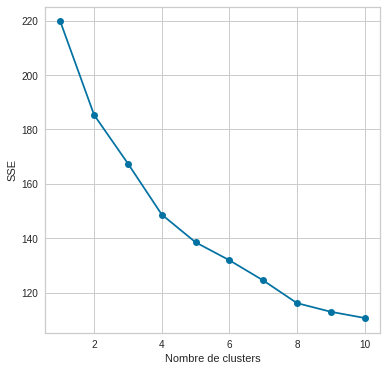

In [123]:
from sklearn.cluster import KMeans
import numpy as np

X = np.array(sentence_vectors)


# Somme des différences entre points et centres de clusters
sse     = []
# Dictionnaire qui contient les résultats de kmeans pour chaque k 
labeled = {}
k_range = list(range(1, 11))

for k in k_range:
    kmeans     = KMeans(n_clusters=k).fit(X)
    sse.append(kmeans.inertia_)
    labeled[k] = kmeans.labels_ 

# Plot SSE = f(k)
plt.figure(figsize=(6, 6))
plt.plot(k_range, sse, '-o')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE');

#kmeans.predict([[0, 0], [12, 3]])
#array([1, 0], dtype=int32)
#kmeans.cluster_centers_


## Reduction de dimentionalité

In [124]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
new_data = pca.transform(X)



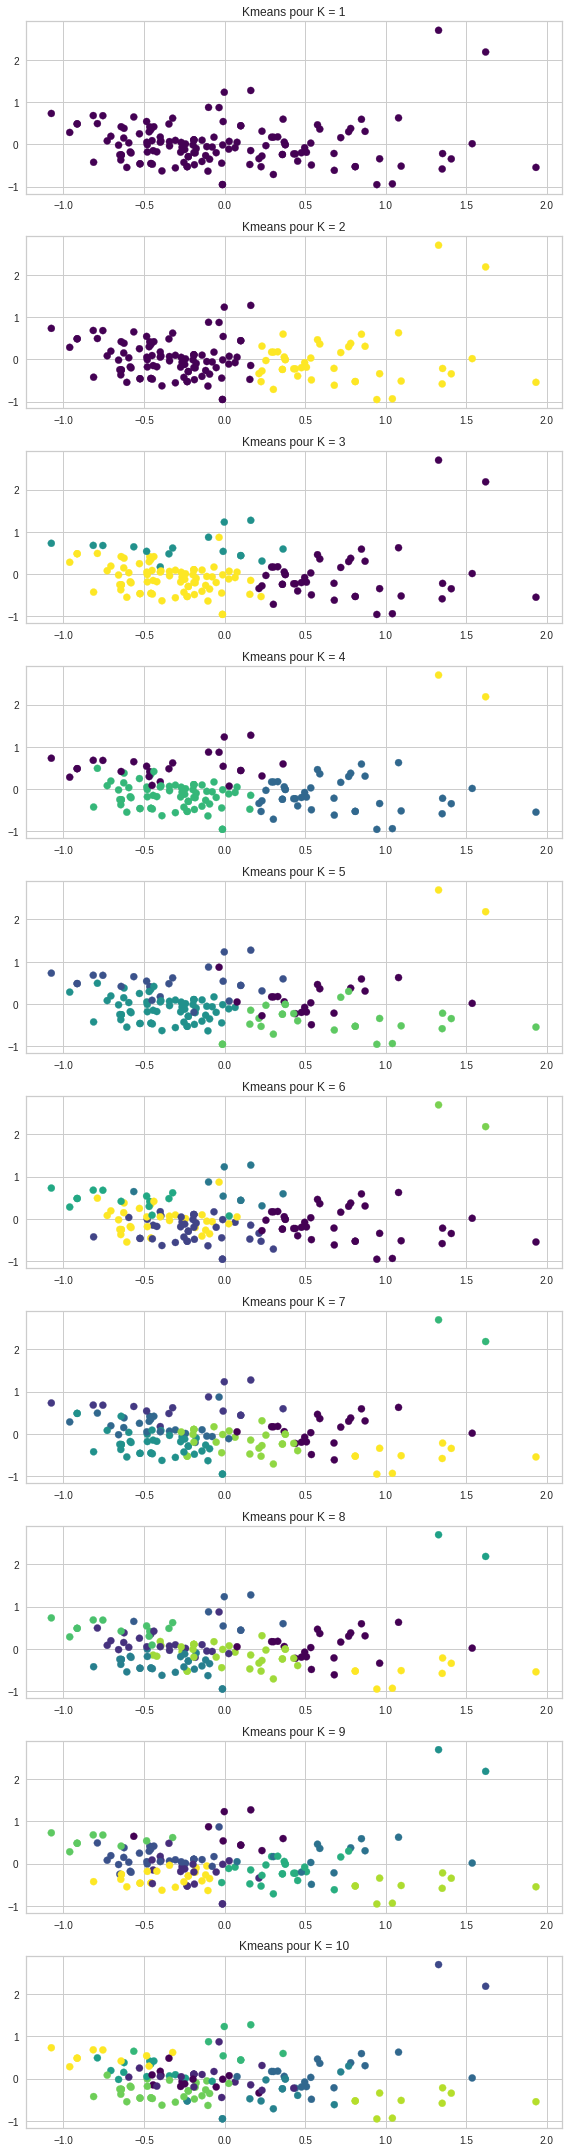

In [125]:
L = list(labeled.keys())
L.sort()

fig, axs = plt.subplots(len(L), figsize = (8,30))



for k in L:
   
    axs[k-1].scatter(new_data[:, 0], new_data[:, 1], c=labeled[k], s=50, cmap='viridis')
    axs[k-1].set_title("Kmeans pour K = {}".format(k))
plt.tight_layout()
plt.show()


## Affichage cas K = 2

In [126]:
# Exemple pour K = 2

sentences_0 = []
sentences_1 = []


for i in range(len(labeled[2])):
    
    if labeled[2][i] == 1:
        sentences_1 += clean_sentences[i]
    else:
        sentences_0 += clean_sentences[i]
        


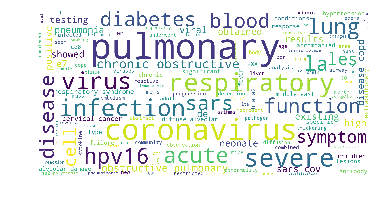

In [127]:
afficherWordCloud(" ".join(sentences_1))

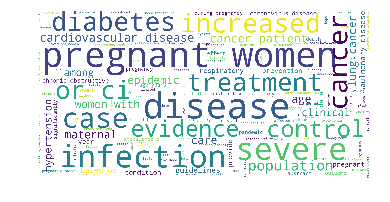

In [128]:
afficherWordCloud(" ".join(sentences_0))

## Affichage cas 3 Clusters

In [116]:
# Exemple pour K = 3

sentences_0 = []
sentences_1 = []
sentences_2 = []



for i in range(len(labeled[3])):
    
    if   labeled[3][i] == 0:
        sentences_0 += clean_sentences[i]
        
    elif labeled[3][i] == 1:
        sentences_1 += clean_sentences[i]
        
    elif labeled[3][i] == 2:
        sentences_2 += clean_sentences[i]
    

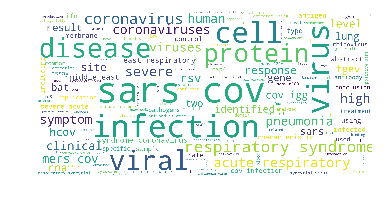

In [117]:
afficherWordCloud(" ".join(sentences_0))

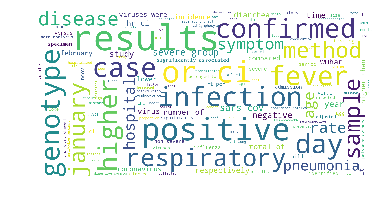

In [118]:
afficherWordCloud(" ".join(sentences_1))

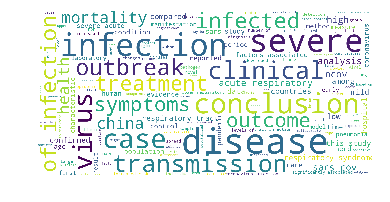

In [119]:
afficherWordCloud(" ".join(sentences_2))

## Elimination des mots de recherche

In [107]:
for tpl in Query:
    STOPWORDS.add(tpl[0])
    STOPWORDS.add(tpl[1])
    


In [112]:
STOPWORDS

{('associated', 'with'),
 ('patients', 'with'),
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'associated',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'covid',
 'detected',
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'found',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 '

In [115]:
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'associated',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'covid',
 'detected',
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'found',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 '